In [630]:
# Imports and functions
import os
import netCDF4 as nc4
import numpy as np
#import numpy.ma as ma

In [631]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [632]:
# User inputs
indir = '/home/disk/bob/gpm/nam_ku/classify/ex_data_v05_testing'
years = ['2016']
months = ['09']
#THRESHOLD = 38.0  #dBZ
THRESHOLD = 0.0  #dBZ
DELTA_HT_FOR_SLOPE = 1.5  #km
#DELTA_HT_FOR_SLOPE = 1.0  #km
#SLOPE = 8.0
SLOPE = 7.5
VERT_RES = 0.125  #km
MAX_BB_HT = 5.0   #km
REFL_MAX_OFFSET = 2.0 #dBZ
STRA = 1
CONV = 2

In [633]:
iyear = years[0]
imonth = months[0]
fname = 'GPM2Ku5_uw3_20160901.204725_to_20160901.205445_014270_NAM.nc'  # dcc case
#fname = 'GPM2Ku5_uw3_20170801.201702_to_20170801.201950_019465_NAM.nc'  # mod case
#fname = 'GPM2Ku5_uw3_20170824.205012_to_20170824.205913_019823_NAM.nc'   # conv case
print(indir+'/'+iyear+'/'+imonth+'/'+fname)

/home/disk/bob/gpm/nam_ku/classify/ex_data_v05_testing/2016/09/GPM2Ku5_uw3_20160901.204725_to_20160901.205445_014270_NAM.nc


In [634]:
ncid = nc4.Dataset(indir+'/'+iyear+'/'+imonth+'/'+fname,'r')
refl = np.array(ncid.variables['refl'])
refl = refl[:,1:,:,:]  # get rid of lowest level due to suspicious data
(ntime,nalt,nlat,nlon) = refl.shape
#refl_missing = ncid.variables['refl'].missing_value
refl_missing = ncid.variables['refl']._FillValue
bin_missing = int(refl_missing)

rt = np.array(ncid.variables['rain_type'])
#rt_missing = ncid.variables['rain_type'].missing_value
rt_missing = ncid.variables['rain_type']._FillValue
#rt[(rt==rt_missing)] = np.nan

rt_uw = np.array(rt, copy=True)

srt = np.array(ncid.variables['shallow_rain_type'])
#srt_missing = ncid.variables['shallow_rain_type'].missing_value
srt_missing = ncid.variables['shallow_rain_type']._FillValue
#srt[(srt==srt_missing)] = np.nan

In [635]:
refl.shape

(1, 175, 429, 266)

In [636]:
# find max_refl and max_refl_ht at each lat/lon
max_refl = np.zeros(rt.shape,dtype=float)+refl_missing
max_refl = np.amax(refl,axis=1)
max_refl_bin = np.zeros(rt.shape,dtype=int)+bin_missing
max_refl_bin = np.argmax(refl,axis=1)
max_refl_ht = max_refl_bin * VERT_RES

max_refl_bin[(max_refl==refl_missing)] = bin_missing
max_refl_ht[(max_refl==refl_missing)] = refl_missing

In [731]:
# initialize reference refl/bin/ht
# these reflect highest refl,bin,ht above max_refl,bin.ht and within +/- REFL_MAX_OFFSET
reference_refl = np.array(max_refl, copy=True)
reference_refl_bin = np.array(max_refl_bin, copy=True)
reference_refl_ht = np.array(max_refl_ht, copy=True)

In [638]:
# find bin & height of highest good refl at each lat/lon
max_ht_bin = np.zeros(rt.shape,dtype=int) + bin_missing
for lev in range(nalt-1,-1,-1):
    max_ht_bin = np.where(np.logical_and((refl[:,lev,:,:] != refl_missing),
                                         (max_ht_bin == bin_missing) ), 
                          lev, max_ht_bin )
max_ht = max_ht_bin * (max_ht_bin != bin_missing) * VERT_RES
max_ht[(max_ht_bin==bin_missing)] = refl_missing

In [ ]:
# For rt_uw, change rain_type to stratiform if:
# 1. rain_type = convective and
# 2. shallow_rain_type = 0 and
# 3. max_refl in column >= THRESHOLD and
# 4. [(dbz @ reference point) - (dbz @ point 1.5km higher)]/
#    [(ht  @ reference point) - (ht  @ point 1.5km higher)] >= abs(SLOPE)
#  as long as ht @ reference point <= MAX_BB_HT

In [639]:
# Determine indices of interest 
change = np.logical_and(np.logical_and(rt==2,srt==0),max_refl>=THRESHOLD)
ind_time,ind_lat,ind_lon = np.where(change==True)
npixels = ind_time.size

In [ ]:
# for each index
#    start at max_refl_ht & go up to find reference refl within +/- REFL_MAX_OFFSET
#    if height of new reference refl is less than MAX_BB_HT
#        determine slope between that point and point DELTA_HT_FOR_SLOPE higher or highest good point in column
#        if slope exceeds SLOPE, change raintype from convective to stratiform

In [ ]:
#for ind in range(0,npixels):
    #itime = ind_time[ind]
    #ilat = ind_lat[ind]
    #ilon = ind_lon[ind]
    # for testing mod file
    #itime = 0
    #ilat = 39
    #ilon = 155
    itime = 0
    ilat = 38
    ilon = 126
    # for testing conv file
    #itime = 0
    #ilat = 355
    #ilon = 145
    if max_refl[itime,ilat,ilon] != refl_missing:
        next_bin = reference_refl_bin[itime,ilat,ilon]+1
        next_ht = reference_refl_ht[itime,ilat,ilon]+VERT_RES
        next_refl = refl[itime,next_bin,ilat,ilon]
        print(reference_refl[itime,ilat,ilon],reference_refl_bin[itime,ilat,ilon],reference_refl_ht[itime,ilat,ilon])
        print(next_refl,next_bin,next_ht)
        while abs(max_refl[itime,ilat,ilon]-next_refl) <= REFL_MAX_OFFSET:
            reference_refl[itime,ilat,ilon]=next_refl
            reference_refl_bin[itime,ilat,ilon] = next_bin
            reference_refl_ht[itime,ilat,ilon]=next_ht  
            next_bin = reference_refl_bin[itime,ilat,ilon]+1
            next_ht = reference_refl_ht[itime,ilat,ilon]+VERT_RES
            next_refl = refl[itime,next_bin,ilat,ilon]
            print(reference_refl[itime,ilat,ilon],reference_refl_bin[itime,ilat,ilon],reference_refl_ht[itime,ilat,ilon])
            print(next_refl,next_bin,next_ht)

        print('Found best reference point')
        print('   reference_refl     =',reference_refl[itime,ilat,ilon])
        print('   reference_refl_bin =',reference_refl_bin[itime,ilat,ilon])
        print('   reference_refl_ht  =',reference_refl_ht[itime,ilat,ilon])

        if reference_refl_ht[itime,ilat,ilon] < MAX_BB_HT:
            if reference_refl_ht[itime,ilat,ilon] + DELTA_HT_FOR_SLOPE <= max_ht[itime,ilat,ilon]:
                compare_bin = reference_refl_bin[itime,ilat,ilon] + int(DELTA_HT_FOR_SLOPE/VERT_RES)
                compare_ht = reference_refl_ht[itime,ilat,ilon] + DELTA_HT_FOR_SLOPE
                compare_refl = refl[itime,compare_bin,ilat,ilon]
            else:
                compare_bin = max_ht_bin[itime,ilat,ilon]
                compare_ht = max_ht[itime,ilat,ilon]
                compare_refl = refl[itime,compare_bin,ilat,ilon]
            if (abs(reference_refl_ht[itime,ilat,ilon] - compare_ht)) != 0.0:
                if ( abs(reference_refl[itime,ilat,ilon] - compare_refl)/
                     abs(reference_refl_ht[itime,ilat,ilon] - compare_ht) ) >= SLOPE:
                    rt_uw[itime,ilat,ilon] = STRA
                

In [ ]:
# STEP BY STEP

In [732]:
itime = 0
#ilat = 127
#ilon = 93
#ilat = 126
#ilon = 91
#ilat = 126
#ilon = 93
ilat = 127
ilon = 93

#ilat = 38
#ilon = 126

#ilat = 37
#ilon = 165
#max_refl[itime,ilat,ilon] != refl_missing

In [733]:
next_bin = reference_refl_bin[itime,ilat,ilon]+1
next_ht = reference_refl_ht[itime,ilat,ilon]+VERT_RES
next_refl = refl[itime,next_bin,ilat,ilon]
print(reference_refl[itime,ilat,ilon],reference_refl_bin[itime,ilat,ilon],reference_refl_ht[itime,ilat,ilon])
print(next_refl,next_bin,next_ht)

(46.995472, 37, 4.625)
(45.837887, 38, 4.75)


In [734]:
while abs(max_refl[itime,ilat,ilon]-next_refl) <= REFL_MAX_OFFSET:
    reference_refl[itime,ilat,ilon]=next_refl
    reference_refl_bin[itime,ilat,ilon] = next_bin
    reference_refl_ht[itime,ilat,ilon]=next_ht  
    next_bin = reference_refl_bin[itime,ilat,ilon]+1
    next_ht = reference_refl_ht[itime,ilat,ilon]+VERT_RES
    next_refl = refl[itime,next_bin,ilat,ilon]
    print(reference_refl[itime,ilat,ilon],reference_refl_bin[itime,ilat,ilon],reference_refl_ht[itime,ilat,ilon])
    print(next_refl,next_bin,next_ht)


(45.837887, 38, 4.75)
(45.885315, 39, 4.875)
(45.885315, 39, 4.875)
(44.456738, 40, 5.0)


In [735]:
print('Found best reference point')
print('   reference_refl     =',reference_refl[itime,ilat,ilon])
print('   reference_refl_bin =',reference_refl_bin[itime,ilat,ilon])
print('   reference_refl_ht  =',reference_refl_ht[itime,ilat,ilon])

Found best reference point
('   reference_refl     =', 45.885315)
('   reference_refl_bin =', 39)
('   reference_refl_ht  =', 4.875)


In [736]:
reference_refl_ht[itime,ilat,ilon] < MAX_BB_HT

True

In [737]:
reference_refl_ht[itime,ilat,ilon] + DELTA_HT_FOR_SLOPE <= max_ht[itime,ilat,ilon]

True

In [738]:
if reference_refl_ht[itime,ilat,ilon] + DELTA_HT_FOR_SLOPE <= max_ht[itime,ilat,ilon]:
    compare_bin = reference_refl_bin[itime,ilat,ilon] + int(DELTA_HT_FOR_SLOPE/VERT_RES)
    compare_ht = reference_refl_ht[itime,ilat,ilon] + DELTA_HT_FOR_SLOPE
    compare_refl = refl[itime,compare_bin,ilat,ilon]
else:
    compare_bin = max_ht_bin[itime,ilat,ilon]
    compare_ht = max_ht[itime,ilat,ilon]
    compare_refl = refl[itime,compare_bin,ilat,ilon]
 
print(compare_refl,compare_bin,compare_ht)

(33.953949, 51, 6.375)


In [739]:
( abs(reference_refl[itime,ilat,ilon] - compare_refl)/abs(reference_refl_ht[itime,ilat,ilon] - compare_ht) ) >= SLOPE        

True

In [740]:
reference_refl[itime,ilat,ilon]

45.885315

In [741]:
compare_refl

33.953949

In [742]:
reference_refl_ht[itime,ilat,ilon]

4.875

In [743]:
compare_ht

6.375

In [744]:
abs(reference_refl_ht[itime,ilat,ilon] - compare_ht)

1.5

In [745]:
abs(reference_refl[itime,ilat,ilon] - compare_refl)

11.931366

In [746]:
( abs(reference_refl[itime,ilat,ilon] - compare_refl)/abs(reference_refl_ht[itime,ilat,ilon] - compare_ht) )

7.954243977864583

In [706]:
# END OF STEP BY STEP

In [747]:
max_refl[itime,ilat,ilon]

46.995472

In [748]:
refl[0,0:45,ilat,ilon]

array([-99.        , -99.        , -99.        , -99.        ,
       -99.        , -99.        , -99.        , -99.        ,
       -99.        , -99.        , -99.        , -99.        ,
        44.81999969,  44.15016937,  44.15399933,  44.16794968,
        44.17202377,  44.17621994,  44.18053436,  44.18424988,
        44.18880463,  44.19347382,  44.19272614,  45.08919144,
        44.95888519,  45.25337982,  44.92152023,  44.79096603,
        45.90945435,  44.5593605 ,  45.11778259,  45.24478149,
        46.05205917,  46.08937836,  46.03396988,  45.53702545,
        46.88890457,  46.99547195,  45.83788681,  45.88531494,
        44.45673752,  44.88173294,  43.76644897,  43.53131485,  42.70576859], dtype=float32)

[]

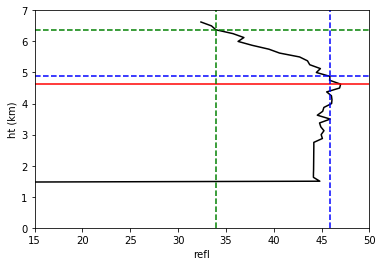

In [749]:
# MOD CASE
#y = range(1, 30)
x = refl[0,0:54,ilat,ilon]
y = np.linspace(0.0,6.625,num=54)
fig = plt.figure()
plt.plot(x, y, '-',color='black')
#plt.plot(x, y, 'o')
plt.xlim(15, 50);
plt.ylim(0.0, 7.0);
plt.xlabel('refl')
plt.ylabel('ht (km)')

x1 = range(15,51)
y1 = np.array([max_refl_ht[itime,ilat,ilon] for i in xrange(len(x1))])
plt.plot(x1, y1, 'r-') 
plt.plot()
#plt.axis('equal')

x2 = range(15,51)
y2 = np.array([reference_refl_ht[itime,ilat,ilon] for i in xrange(len(x2))])
plt.plot(x2, y2, 'b--') 
plt.plot()
#plt.axis('equal')

x3 = range(15,51)
y3 = np.array([compare_ht for i in xrange(len(x3))])
plt.plot(x3, y3, 'g--') 
plt.plot()
#plt.axis('equal')

y4 = range(0,8)
x4 = np.array([reference_refl[itime,ilat,ilon] for i in xrange(len(y4))])
plt.plot(x4, y4, 'b--') 
plt.plot()
#plt.axis('equal')

y5 = range(0,8)
x5 = np.array([compare_refl for i in xrange(len(y5))])
plt.plot(x5, y5, 'g--') 
plt.plot()
#plt.axis('equal')



In [657]:
ncid.close()